In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
data_train = pd.read_csv("./train_clean.csv")
data_test = pd.read_csv("./test_clean.csv")

**1.Find a stock that has seasonality in the feature 'Adj Close'. Plot signals from the selected stock using the function from the first exercise.**

In [25]:
def plot_stock_trends(stock_data, symbol, features, ax=None):
    stock_specific_data = stock_data.loc[stock_data['Symbol'] == symbol].copy()
    stock_specific_data['Date'] = pd.to_datetime(stock_specific_data['Date'])
    
    # Create a new figure and axis object if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot each feature on the y-axis
    for feature in features:
        ax.plot(stock_specific_data['Date'], stock_specific_data[feature], label=feature)
    
    # Formatting the plot
    ax.set_title(f'Stock Trends for {symbol}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    
    return ax

In [26]:
PERIOD = 180

def detectSeasonality(data, symbol):
    stockData = data[data['Symbol'] == symbol].copy()
    stockData['Date'] = pd.to_datetime(stockData['Date'])
    stockData.set_index('Date', inplace=True)
    
    adj_close = stockData['Adj Close'].resample('D').mean().interpolate()
    
    # dekompozicija vremenskog niza
    decomposition = sm.tsa.seasonal_decompose(adj_close, model='additive', period=PERIOD) 
    seasonal_strength = decomposition.seasonal.var() / adj_close.var()
    return seasonal_strength

seasonality_strengths = []

for symbol in data_train['Symbol'].unique():
    if len(data_train[data_train['Symbol'] == symbol]) < (PERIOD * 2):
        continue
    strength = detectSeasonality(data_train, symbol)
    seasonality_strengths.append((symbol, strength))

# sortiranje po snazi sezonalnosti
seasonality_strengths.sort(key=lambda x: x[1], reverse=True)

strongest_seasonal_stock = seasonality_strengths[0][0]
strongest_seasonal_strength = seasonality_strengths[0][1]

print("Stock with the strongest seasonality:", strongest_seasonal_stock)
print("Seasonality strength:", strongest_seasonal_strength)

Stock with the strongest seasonality: FTV
Seasonality strength: 0.013204914471771906


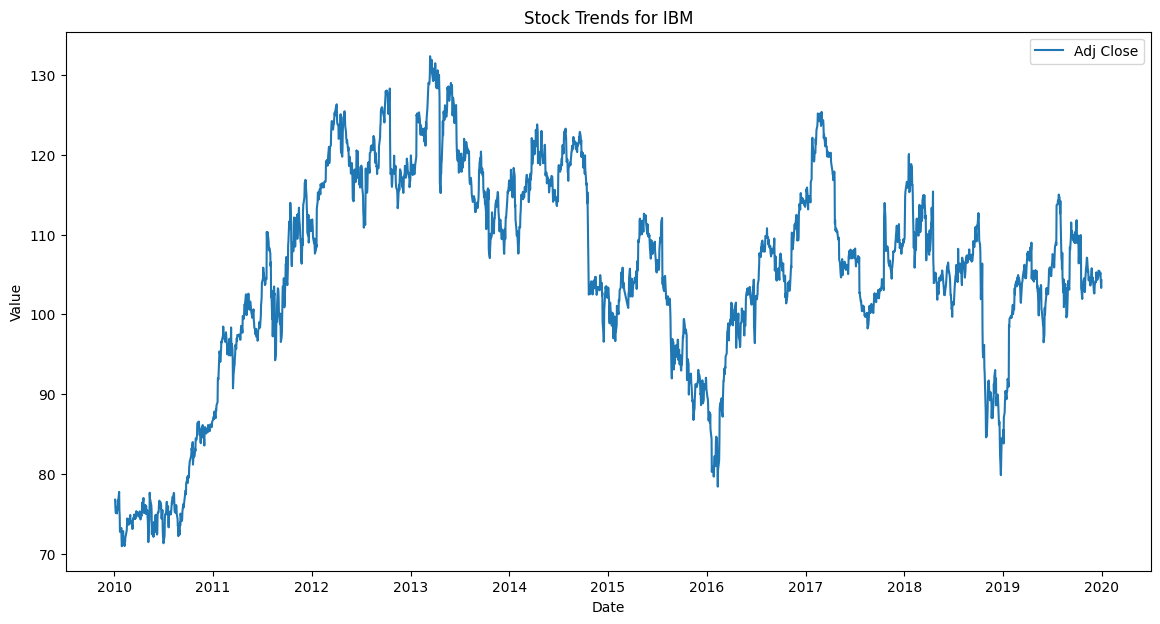

In [27]:
features = ['Adj Close']
plot_stock_trends(data_train, 'IBM', features)
plt.show()


**2. Exponential smoothing**

C:\Users\kpali\AppData\Local\Temp\ipykernel_11524\3649245900.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  IBMData = IBMData.asfreq('D').fillna(method='ffill')


RMSE: 18.299288240234073
MAE: 16.141293669338108


C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


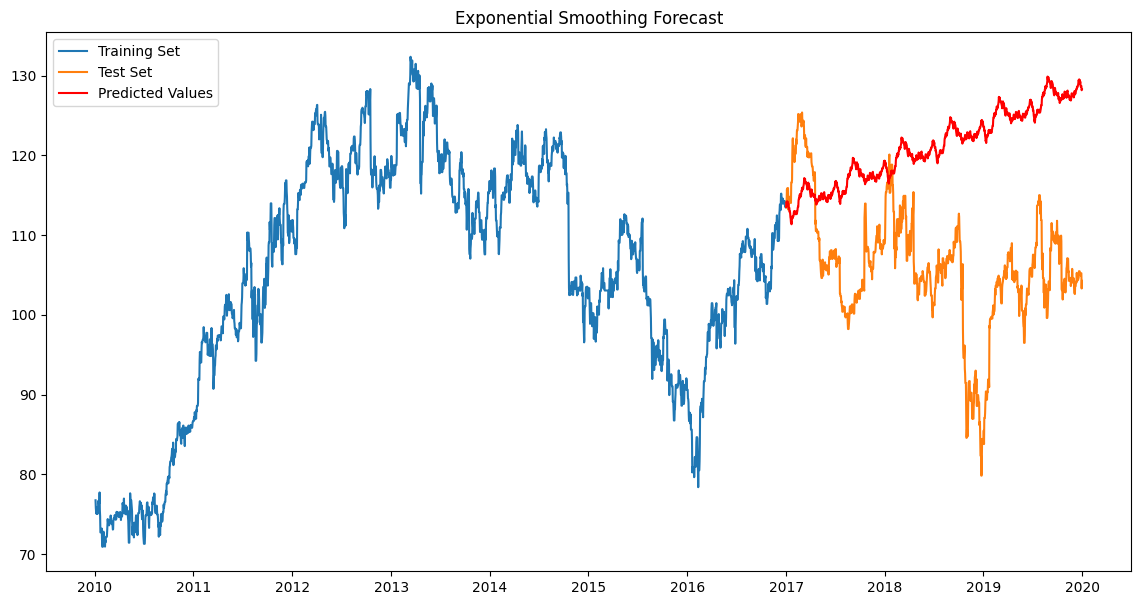

In [28]:
IBMData = data_train[data_train['Symbol'] == 'IBM'].copy()
IBMData['Date'] = pd.to_datetime(IBMData['Date'])
IBMData.set_index('Date', inplace=True)

IBMData = IBMData.asfreq('D').fillna(method='ffill')

# 70% podataka koristimo za treniranje, a 30% za testiranje
train, test = train_test_split(IBMData, test_size=0.3, shuffle=False)

y_train = train['Adj Close']
y_test = test['Adj Close']

model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=PERIOD).fit()
y_pred = model.forecast(len(y_test))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Training Set')
plt.plot(test.index, y_test, label='Test Set')
plt.plot(test.index, y_pred, label='Predicted Values', color='red')
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.show()

**Optimizacija nije uspjela zbog nekoliko potencijalnih razloga**

**Problemi s konvergencijom**: Model se možda ne može konvergirati s određenim kombinacijama trenda i sezonskih komponenti.

**Neprikladno sezonsko razdoblje**: Navedeno sezonsko razdoblje možda nije prikladno za podatke.

**Nedovoljno podataka**: Možda nema dovoljno podataka za učinkovito procjenjivanje parametara modela.

C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kpali\AppData\Roaming\Pyth

Best Parameters: Trend=add, Seasonal=mul
Optimized RMSE: 10.029843342054333
Optimized MAE: 8.102634020654733


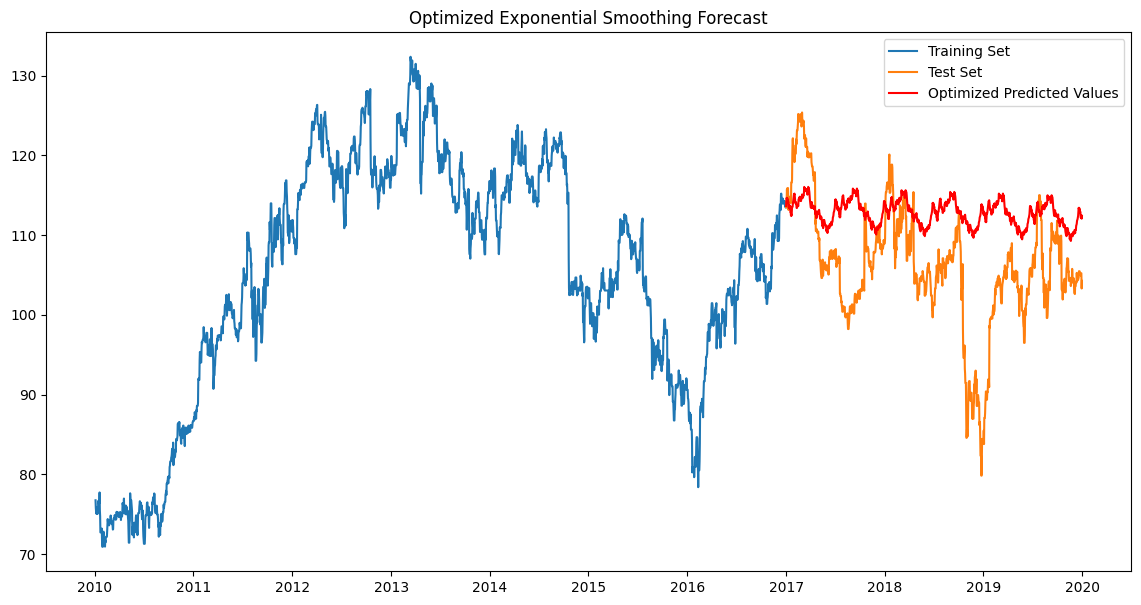

  Trend Seasonal  Seasonal Periods       RMSE       MAE
0   add      mul               180  10.029843  8.102634


In [29]:
# Parameter optimization
def parameterOptimization(y_train, y_test):
    best_rmse = float('inf')
    best_params = None
    best_model = None
    
    trends = ['add', 'mul']
    seasonals = ['add', 'mul']
    periods = [30, 90, 180, 260, 365]
    
    for trend in trends:
        for seasonal in seasonals:
            for period in periods:
                try:
                    model = ExponentialSmoothing(y_train, trend=trend, seasonal=seasonal, seasonal_periods=period).fit()
                    y_pred = model.forecast(len(y_test))
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                    
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_mae = mae
                        best_params = (trend, seasonal, period)
                        best_model = model
                except Exception as e:
                    print(f"Model failed for trend={trend}, seasonal={seasonal}. Error: {e}")
                    continue
    
    return best_model, best_params, best_rmse, best_mae



best_model, best_params, best_rmse, best_mae = parameterOptimization(y_train, y_test)

# Display optimized results
print(f'Best Parameters: Trend={best_params[0]}, Seasonal={best_params[1]}')
print(f'Optimized RMSE: {best_rmse}')
print(f'Optimized MAE: {best_mae}')

# Plot the results with optimized model
y_pred_optimized = best_model.forecast(len(y_test))

plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Training Set')
plt.plot(test.index, y_test, label='Test Set')
plt.plot(test.index, y_pred_optimized, label='Optimized Predicted Values', color='red')
plt.legend()
plt.title('Optimized Exponential Smoothing Forecast')
plt.show()

# Table of the parameters used and the errors obtained
results = {
    'Trend': [best_params[0]],
    'Seasonal': [best_params[1]],
    'Seasonal Periods': [best_params[2]],
    'RMSE': [best_rmse],
    'MAE': [best_mae]
}

results_df = pd.DataFrame(results)
print(results_df)

**4. ARIMA**

C:\Users\kpali\AppData\Local\Temp\ipykernel_11524\2759791138.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  IBMData = IBMData.asfreq('D').fillna(method='ffill')


RMSE: 7.905750175488842
MAE: 5.556657546978701


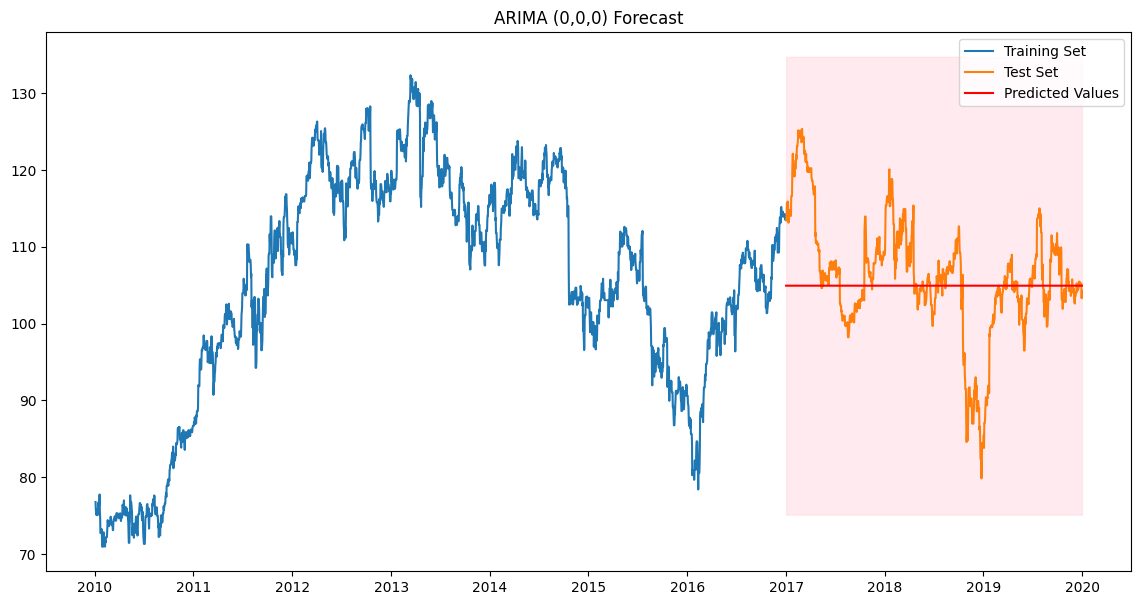

In [30]:
SEASONAL_PERIOD = 180
TREND = 'add'
SEASONAL = 'mul'

IBMData = data_train[data_train['Symbol'] == 'IBM'].copy()
IBMData['Date'] = pd.to_datetime(IBMData['Date'])
IBMData.set_index('Date', inplace=True)

IBMData = IBMData.asfreq('D').fillna(method='ffill')
train, test = train_test_split(IBMData, test_size=0.3, shuffle=False)

y_train = train['Adj Close']
y_test = test['Adj Close']

model = ARIMA(y_train, order=(0,0,0)).fit()
y_pred = model.forecast(len(y_test))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Training Set')
plt.plot(test.index, y_test, label='Test Set')
plt.plot(test.index, y_pred, label='Predicted Values', color='red')
plt.fill_between(test.index, model.get_forecast(len(y_test)).conf_int().iloc[:, 0], model.get_forecast(len(y_test)).conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('ARIMA (0,0,0) Forecast')
plt.show()

Svrha ove linije je vizualno pokazati raspon unutar kojeg se očekuju stvarne vrijednosti s određenom razinom pouzdanosti (obično 95%). Širina intervala pouzdanosti pruža uvid u nesigurnost predikcija. Širi interval sugerira veću nesigurnost, dok uži interval sugerira veću pouzdanost u predikcije.

Širok interval pouzdanosti, kao što je prikazano na grafu, sugerira visoki stupanj nesigurnosti u prognozi. To znači da model nije siguran u točne buduće vrijednosti i predviđanja su vrlo neizvjesna.

In [31]:
def ARIMAOptimization(y_train, y_test, p_values = [0], d_values = [0], q_values = [0]):
    best_rmse = float('inf')
    best_pdq = None
    best_model = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(y_train, order=(p,d,q)).fit()
                    y_pred = model.forecast(len(y_test))
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                    
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_mae = mae
                        best_pdq = [p, d, q]
                        best_model = model
                except Exception as e:
                    print(f"Model nije uspio za p={p}, d={d}, q={q}. Greška: {e}")
                    continue
                
    
    return best_model, best_pdq, best_rmse, best_mae

In [32]:
def bestResultARIMAGraph(y_train, y_test, best_model, best_pdq, best_rmse_p, best_mae_p):
    print(f'Najbolji p: {best_pdq[0]}')
    print(f'Najbolji d: {best_pdq[1]}')
    print(f'Najbolji q: {best_pdq[2]}')
    print(f'Optimizirani RMSE: {best_rmse_p}')
    print(f'Optimizirani MAE: {best_mae_p}')

    y_pred_p = best_model.forecast(len(y_test))

    plt.figure(figsize=(14, 7))
    plt.plot(train.index, y_train, label='Trenirani skup')
    plt.plot(test.index, y_test, label='Testni skup')
    plt.plot(test.index, y_pred_p, label=f'Predviđene vrijednosti s p={best_pdq[0]} d={best_pdq[1]} q={best_pdq[2]} ', color='red')
    plt.fill_between(test.index, best_model.get_forecast(len(y_test)).conf_int().iloc[:, 0], best_model.get_forecast(len(y_test)).conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.legend()
    plt.title(f'ARIMA ({best_pdq[0]},{best_pdq[1]},{best_pdq[2]}) Predikcija')
    plt.show()

Najbolji p: 2
Najbolji d: 0
Najbolji q: 0
Optimizirani RMSE: 7.2100835999695585
Optimizirani MAE: 5.208164072351769


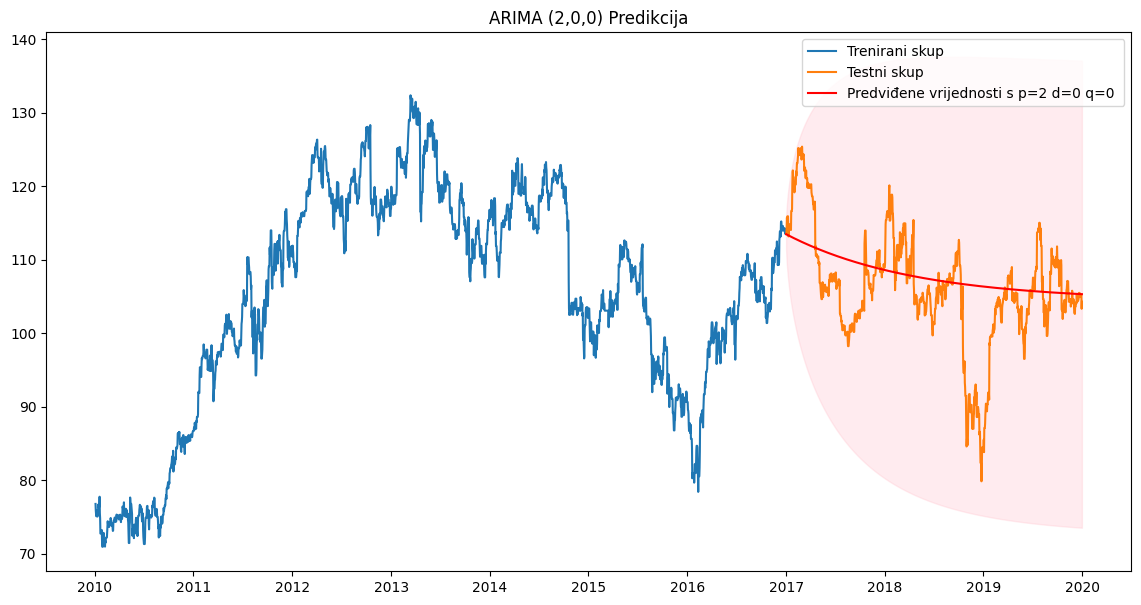

In [33]:
p_values = range(0, 6)
best_model, best_pdq, best_rmse, best_mae = ARIMAOptimization(y_train, y_test, p_values)
bestResultARIMAGraph(y_train, y_test, best_model, best_pdq, best_rmse, best_mae)



U ovom slučaju, graf prikazuje predikcije ARIMA modela s parametrima p=2, d=0, i q=0. Zasjenjeno područje u grafu predstavlja interval pouzdanosti za te predikcije. Vidljivo je da interval pouzdanosti postaje sve širi kako se udaljavamo od početka prognoze, što ukazuje na povećanu nesigurnost u dugoročnim predikcijama i sigurniju predikciju u kratkoročnim predikcijama

Model s p=2 uzima u obzir posljednja dva zaostala opažanja. To omogućuje modelu da uhvati kratkoročne ovisnosti i obrasce u podacima.
Predikcije će reflektirati kratkoročne fluktuacije bolje nego model s p=0 (koji uopće ne uzima u obzir prošle vrijednosti).


C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Najbolji p: 0
Najbolji d: 0
Najbolji q: 5
Optimizirani RMSE: 7.891919693978167
Optimizirani MAE: 5.538591462169382


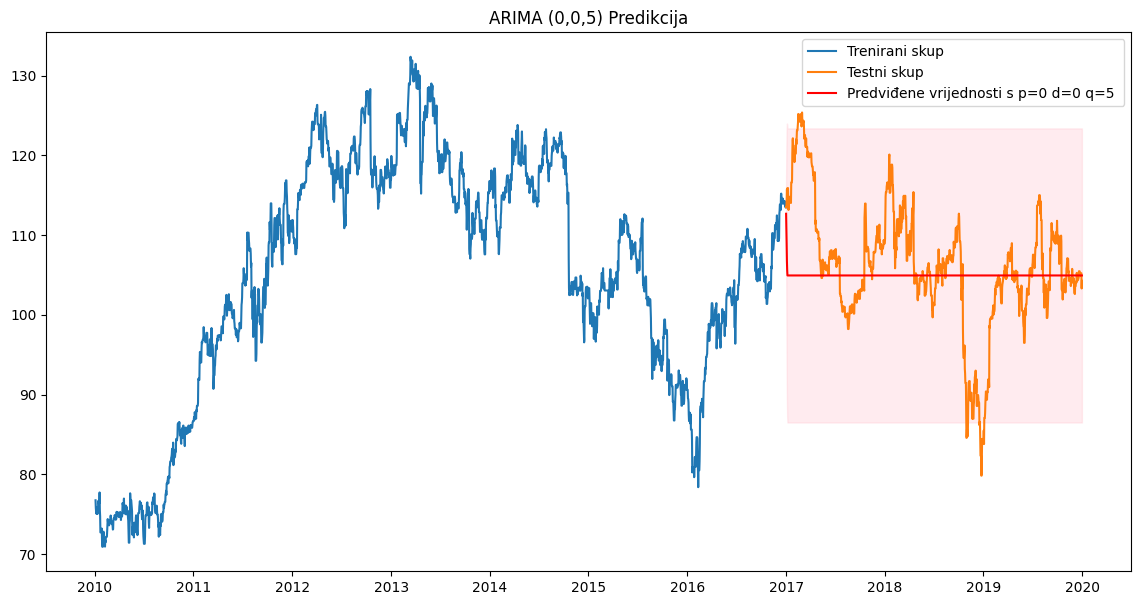

In [34]:
q_values = range(0, 6)
best_model, best_pdq, best_rmse, best_mae = ARIMAOptimization(y_train, y_test, q_values=q_values)
bestResultARIMAGraph(y_train, y_test, best_model, best_pdq, best_rmse, best_mae)



Parametar q u ARIMA modelu predstavlja broj prošlih pogrešaka uključenih u model, odnosno pomični prosjek (MA) dio modela. Pomični prosjek koristi prošle pogreške u predviđanju trenutne vrijednosti vremenske serije.

Parametar q pomaže u uklanjanju šuma iz vremenske serije. Korištenjem prošlih pogrešaka, model može bolje predvidjeti trenutne vrijednosti i smanjiti utjecaj nasumičnih varijacija. Uključivanjem prošlih pogrešaka, model može bolje uhvatiti obrasce u podacima koji se ne mogu objasniti samo s trenutnim i prošlim vrijednostima (što radi autoregresivni dio modela).

Model s većim q može brže reagirati na promjene u vremenskoj seriji jer uzima u obzir više prošlih pogrešaka. To može biti korisno u serijama koje pokazuju brze ili nepredvidive promjene.

Najbolji p: 0
Najbolji d: 0
Najbolji q: 0
Optimizirani RMSE: 7.905750175488842
Optimizirani MAE: 5.556657546978701


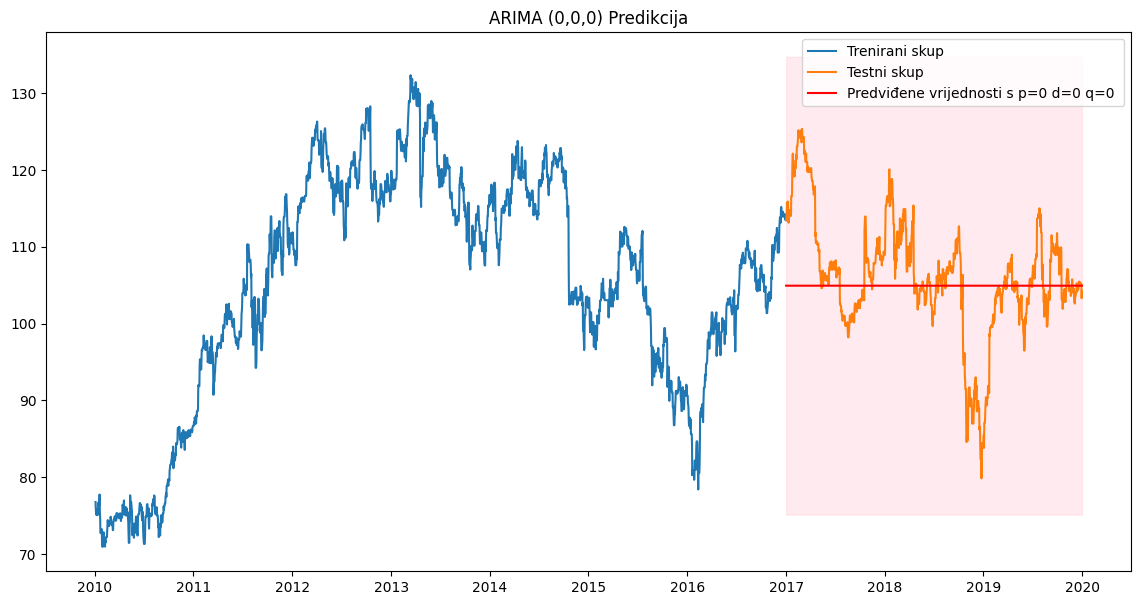

In [35]:
d_values = range(0, 3)
best_model, best_pdq, best_rmse, best_mae = ARIMAOptimization(y_train, y_test, d_values=d_values)
bestResultARIMAGraph(y_train, y_test, best_model, best_pdq, best_rmse, best_mae)

Parametar d u ARIMA modelu predstavlja broj diferenciranja potrebnih za stacioniranje vremenske serije. Diferenciranje uklanja trend i sezonske komponente, čime se postiže stacionarnost serije, što je bitno za ARIMA modeliranje.

Ako je d=0, serija se ne diferencira i model može biti pristran prema trendovima i sezonalnostima prisutnima u podacima.

Ako je d=1, serija se diferencira jednom, što uklanja linearni trend i može poboljšati stacionarnost serije.

Ako je d=2, serija se diferencira dva puta, što uklanja kvadratni trend, ali može dovesti do prekomjernog diferenciranja i previše glatkih predikcija.

C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

Najbolji p: 2
Najbolji d: 0
Najbolji q: 2
Optimizirani RMSE: 6.87396647889643
Optimizirani MAE: 4.9967654074478265


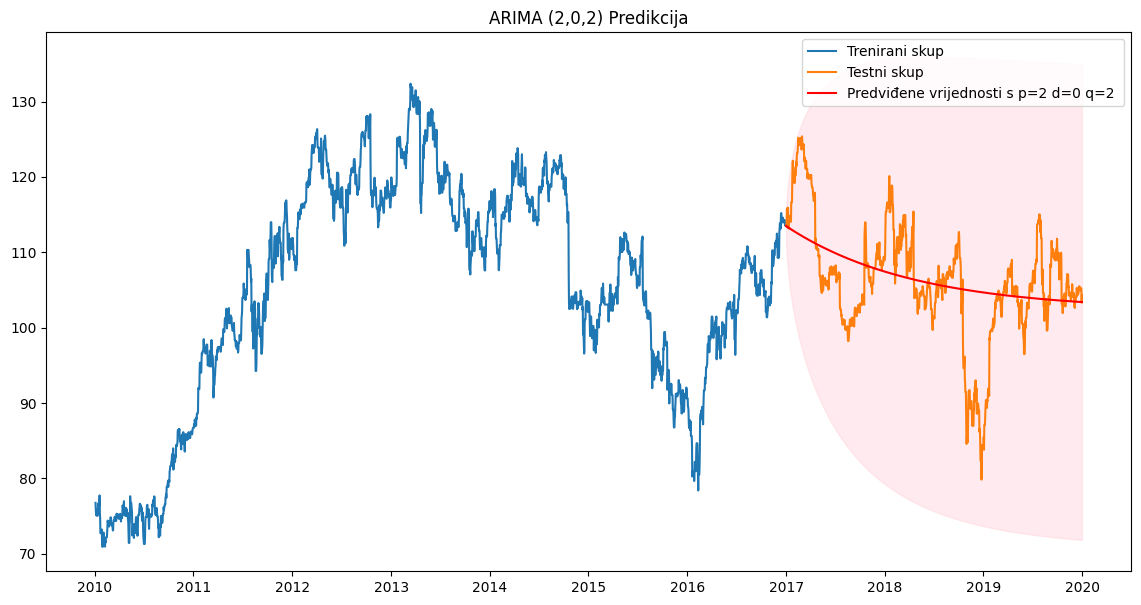

In [36]:
p_values = range(1, 6)
q_values = range(1, 6)
d_values = range(0, 3)
best_model, best_pdq, best_rmse, best_mae = ARIMAOptimization(y_train, y_test, p_values, d_values, q_values)
bestResultARIMAGraph(y_train, y_test, best_model, best_pdq, best_rmse, best_mae)

kombinacija (2, 0, 2) je dala najbolji rezultat RMSE i MAE


Najbolji sezonski parametar: s=7
Optimizirani RMSE: 14.20384689970288
Optimizirani MAE: 12.32160135109078


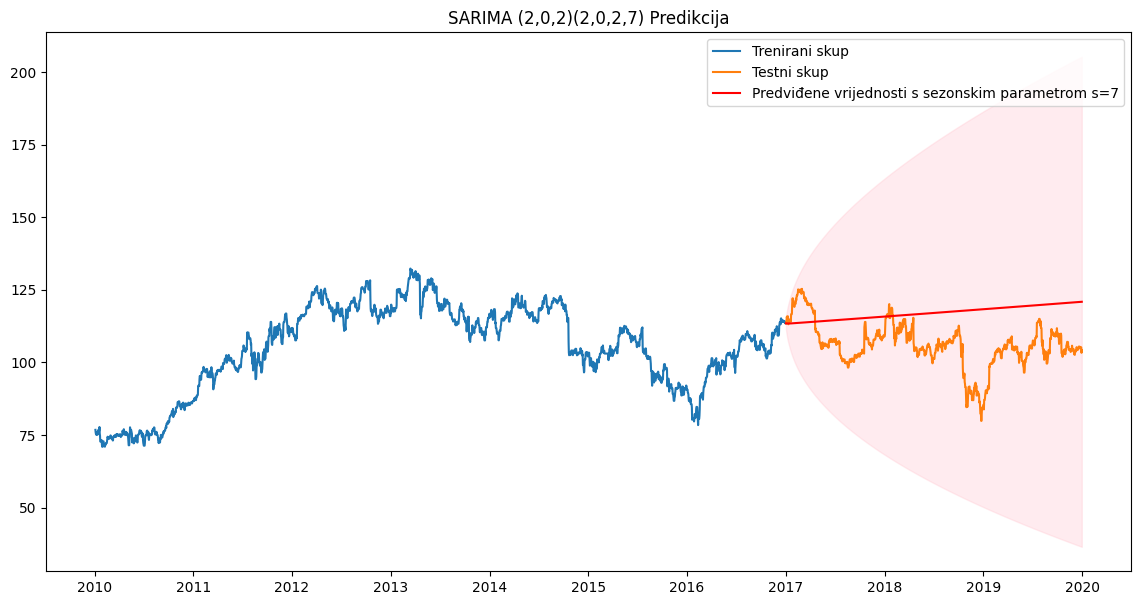

   p  d  q  s       RMSE        MAE
0  2  0  2  7  14.203847  12.321601


In [37]:
def optimize_sarima(y_train, y_test, p, d, q, s_values):
    best_rmse = float('inf')
    best_s = None
    best_model = None
    
    for s in s_values:
        if s > 1:  # Sezonski period mora biti veći od 1
            try:
                model = SARIMAX(y_train, order=(p,d,q), seasonal_order=(p,d,q,s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=1000)
                y_pred = model.forecast(len(y_test))
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_mae = mae
                    best_s = s
                    best_model = model
            except Exception as e:
                print(f"Model nije uspio za s={s}. Greška: {e}")
                continue
    
    return best_model, best_s, best_rmse, best_mae

# Definiranje raspona vrijednosti za sezonski parametar s
s_values = range(6, 13)  # Izbjegavanje konfliktnih vrijednosti
best_sarima_model, best_s, best_rmse_s, best_mae_s = optimize_sarima(y_train, y_test, 2, 0, 2, s_values)

# Prikaz optimiziranih rezultata za sezonski parametar s
print(f'Najbolji sezonski parametar: s={best_s}')
print(f'Optimizirani RMSE: {best_rmse_s}')
print(f'Optimizirani MAE: {best_mae_s}')

# Prikaz rezultata s optimiziranim sezonskim parametrom s
y_pred_s = best_sarima_model.forecast(len(y_test))

plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Trenirani skup')
plt.plot(test.index, y_test, label='Testni skup')
plt.plot(test.index, y_pred_s, label=f'Predviđene vrijednosti s sezonskim parametrom s={best_s}', color='red')
plt.fill_between(test.index, best_sarima_model.get_forecast(len(y_test)).conf_int().iloc[:, 0], best_sarima_model.get_forecast(len(y_test)).conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title(f'SARIMA (2,0,2)(2,0,2,{best_s}) Predikcija')
plt.show()

# Tablica s parametrima i pripadajućim pogreškama
results = {
    'p': [2],
    'd': [0],
    'q': [2],
    's': [best_s],
    'RMSE': [best_rmse_s],
    'MAE': [best_mae_s]
}

results_df = pd.DataFrame(results)
print(results_df)

Bolji su rezultati bez uključivanja sezonalnosti

**4. Facebook Prophet**

19:00:03 - cmdstanpy - INFO - Chain [1] start processing
19:00:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties

RMSE: 17.672846283458252, MAE: 15.222070416112516


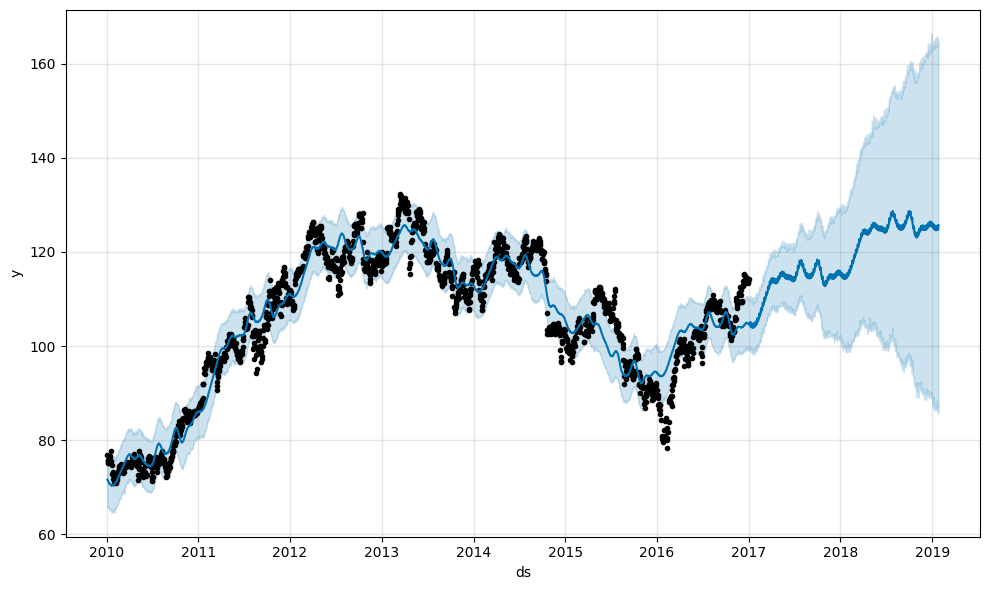

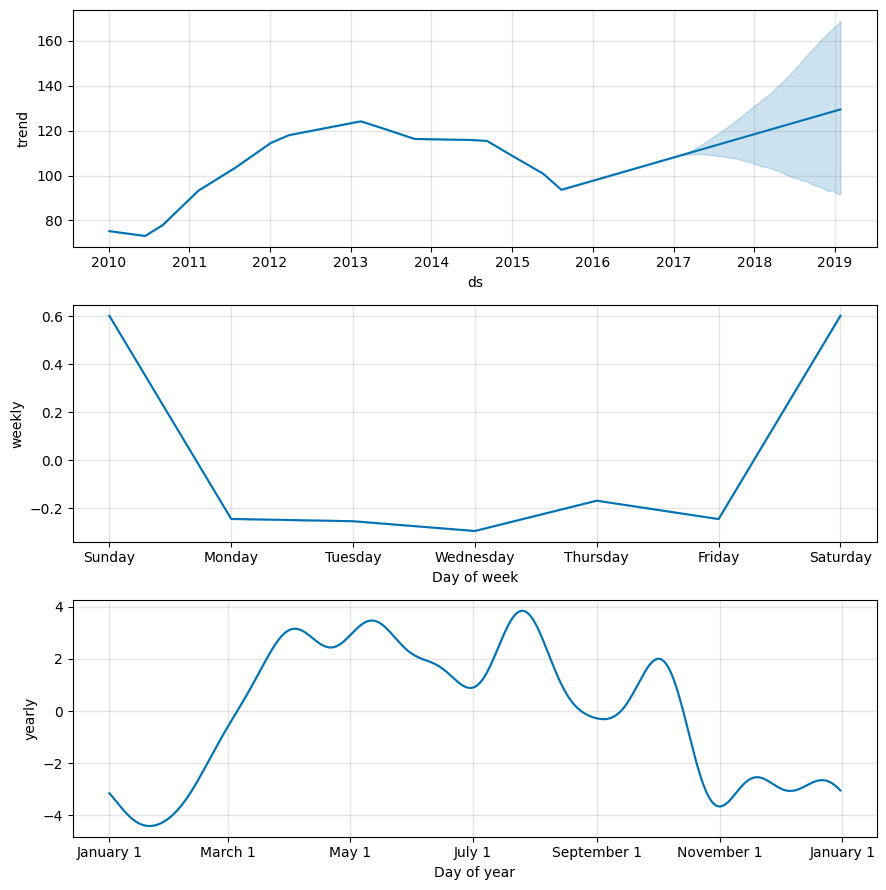

In [38]:
from prophet import Prophet


IBMData = data_train[data_train['Symbol'] == 'IBM'].copy()
IBMData['Date'] = pd.to_datetime(IBMData['Date'])
IBMData = IBMData[['Date', 'Adj Close']].rename(columns={'Date': 'ds', 'Adj Close': 'y'})

# Train and predict using Prophet
def train_predict_prophet(data):
    
    # Split data into train and test sets
    train, test = train_test_split(data, test_size=0.3, shuffle=False)
    
    # Initialize and train the Prophet model
    model = Prophet()
    model.fit(train)
    
    # Make future dataframe and predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    
    # Calculate errors
    y_true = test['y'].values
    y_pred = forecast['yhat'].iloc[len(train):].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Plot the predictions
    fig1 = model.plot(forecast)
    fig2 = model.plot_components(forecast)
    
    return model, forecast, rmse, mae

# Train and predict for the most seasonal stock
model, forecast, rmse, mae = train_predict_prophet(IBMData)
print(f"RMSE: {rmse}, MAE: {mae}")


C:\Users\kpali\AppData\Local\Temp\ipykernel_11524\1677845654.py:15: FutureWarning: 'A-APR' is deprecated and will be removed in a future version, please use 'YE-APR' instead.
  agm_dates = pd.date_range(start='2010-04-01', end='2019-04-30', freq='A-APR').strftime('%Y-%m-%d').tolist()
19:00:05 - cmdstanpy - INFO - Chain [1] start processing
19:00:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Updated RMSE: 17.815217890189263, Updated MAE: 15.361696562390195
  Stock  Yearly Fourier Order  Weekly Fourier Order  Holidays Included  \
0   IBM                    10                     3               True   

        RMSE        MAE  
0  17.815218  15.361697  


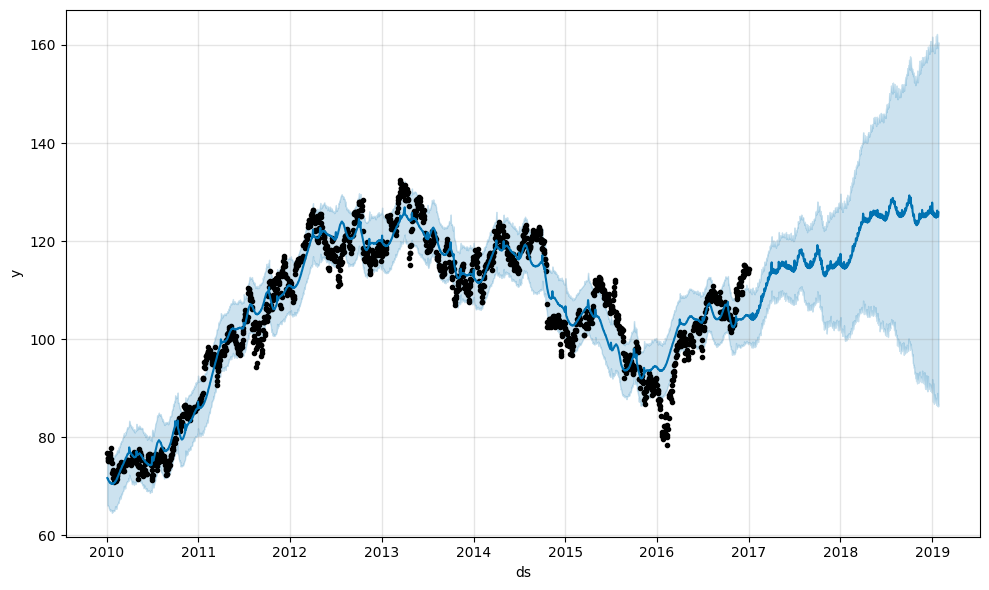

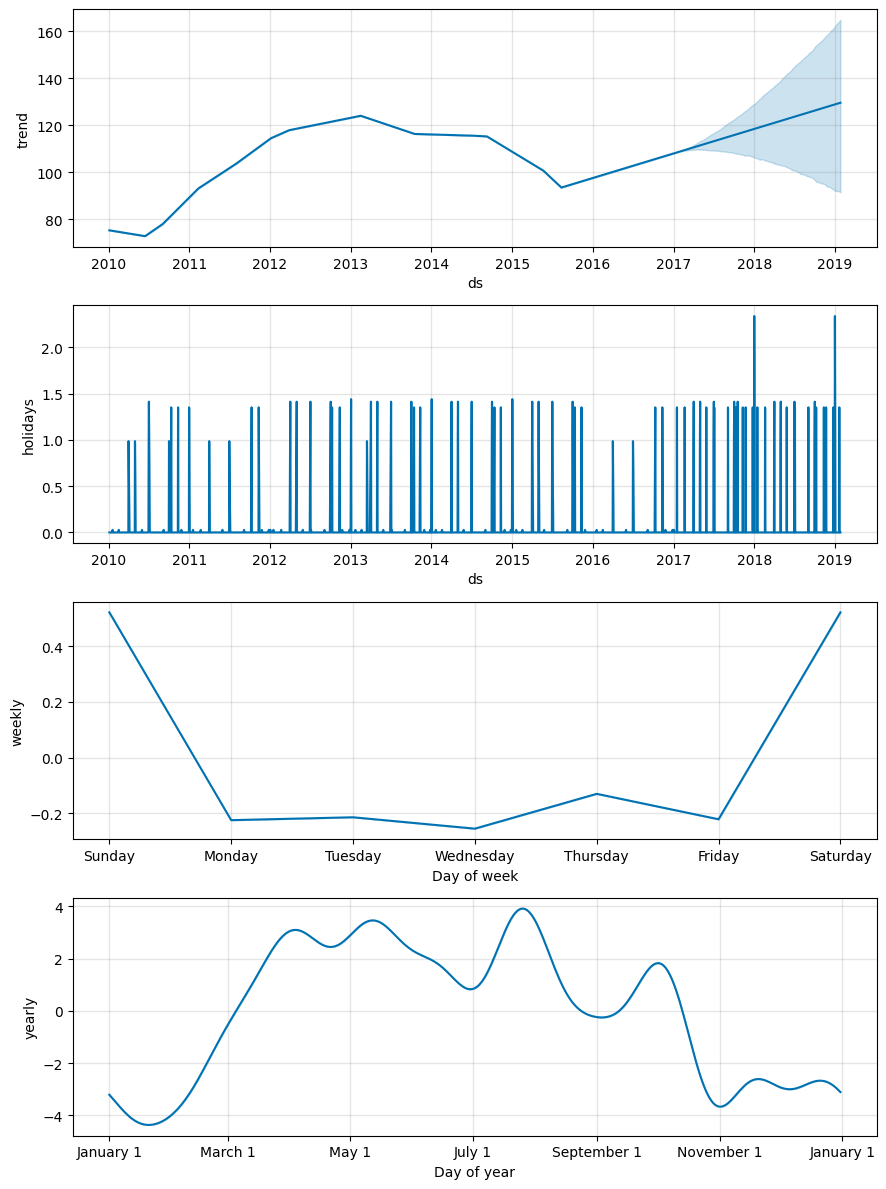

In [39]:
from pandas.tseries.holiday import USFederalHolidayCalendar

us_holidays = USFederalHolidayCalendar().holidays(start='2010-01-01', end='2019-12-31').to_pydatetime()

# Define specific events
additional_holidays = [
    '2012-01-01',  # Ginni Rometty became CEO of IBM
    '2013-03-15',  # IBM’s stock hit its all-time high
    '2017-10-17'   # 22nd consecutive quarter of declining revenue
]

# Quarterly earnings releases
earnings_releases = pd.date_range(start='2010-01-01', end='2019-12-31', freq='QS-JAN').strftime('%Y-%m-%d').tolist()
# Annual General Meetings in April
agm_dates = pd.date_range(start='2010-04-01', end='2019-04-30', freq='A-APR').strftime('%Y-%m-%d').tolist()

all_significant_dates = additional_holidays + earnings_releases + agm_dates
all_significant_dates = list(set(all_significant_dates))  # Remove duplicates

holidays = pd.DataFrame({
    'holiday': 'significant_event',
    'ds': pd.to_datetime(all_significant_dates),
    'lower_window': 0,
    'upper_window': 1,
})

# Convert US holidays to DataFrame
us_holidays_df = pd.DataFrame({
    'holiday': 'us_holiday',
    'ds': pd.to_datetime(us_holidays),
    'lower_window': 0,
    'upper_window': 1,
})

# Combine holidays and significant events
all_holidays = pd.concat([holidays, us_holidays_df])

def train_predict_prophet_with_updated_holidays(data, holidays):
    
    train, test = train_test_split(data, test_size=0.3, shuffle=False)
    
    # Initialize and train the Prophet model
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        holidays=holidays
    )
    model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
    model.add_seasonality(name='weekly', period=7, fourier_order=3)
    
    model.fit(train)
    
    # Make future dataframe and predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    
    # Calculate errors
    y_true = test['y'].values
    y_pred = forecast['yhat'].iloc[len(train):].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Plot the predictions
    fig1 = model.plot(forecast)
    fig2 = model.plot_components(forecast)
    
    return model, forecast, rmse, mae

model_updated, forecast_updated, rmse_updated, mae_updated = train_predict_prophet_with_updated_holidays(IBMData, all_holidays)
print(f"Updated RMSE: {rmse_updated}, Updated MAE: {mae_updated}")

updated_parameters = {
    'Stock': 'IBM',
    'Yearly Fourier Order': 10,
    'Weekly Fourier Order': 3,
    'Holidays Included': True,
    'RMSE': rmse_updated,
    'MAE': mae_updated
}

updated_parameters_df = pd.DataFrame([updated_parameters])
print(updated_parameters_df)


**5. Random Forest Regressor**

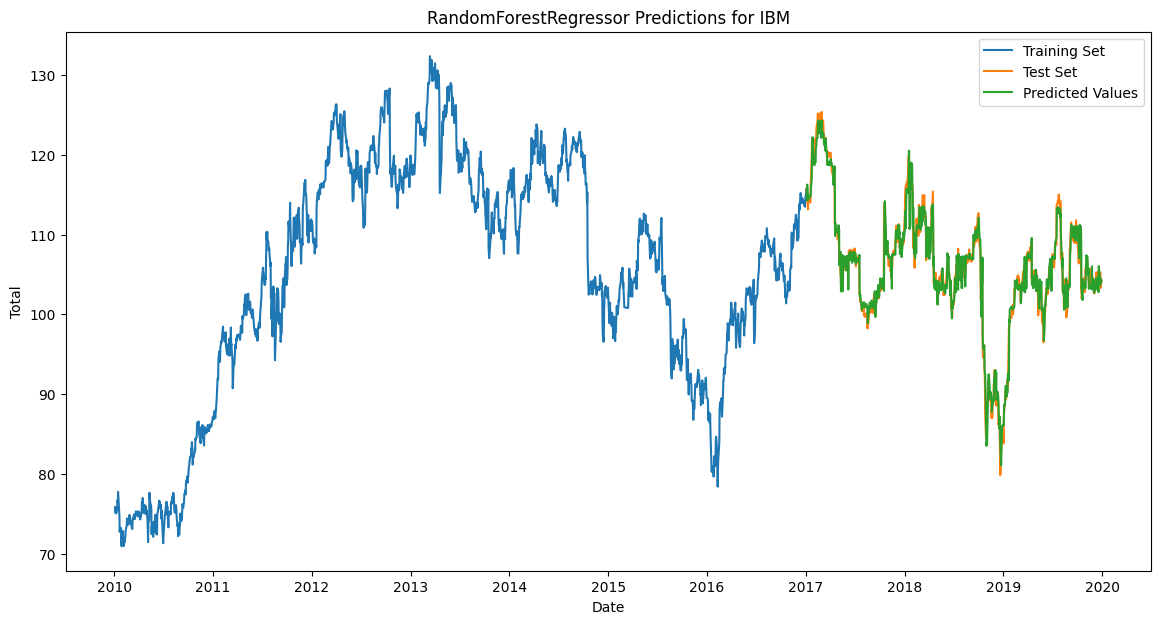

                   Model Stock      RMSE       MAE
0  RandomForestRegressor   IBM  1.609007  1.171458


In [40]:
from sklearn.ensemble import RandomForestRegressor


IBMData = data_train[data_train['Symbol'] == 'IBM'].copy()
IBMData['Date'] = pd.to_datetime(IBMData['Date'])
IBMData.set_index('Date', inplace=True)
IBMData = IBMData.drop(columns=['Symbol'])
IBMData['Total'] = IBMData['Adj Close'].shift(-1)
IBMData = IBMData.dropna()

# Train and predict using RandomForestRegressor
def train_predict_rf(data):

    train, test = train_test_split(data, test_size=0.3, shuffle=False)
    
    # Features and target
    X_train = train.drop(columns=['Total'])
    y_train = train['Total']
    X_test = test.drop(columns=['Total'])
    y_test = test['Total']
    
    # Initialize and train the RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate errors
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(IBMData.index[:len(train)], y_train, label='Training Set')
    plt.plot(IBMData.index[len(train):], y_test, label='Test Set')
    plt.plot(IBMData.index[len(train):], y_pred, label='Predicted Values')
    plt.title(f'RandomForestRegressor Predictions for IBM')
    plt.xlabel('Date')
    plt.ylabel('Total')
    plt.legend()
    plt.show()
    
    return model, rmse, mae


# Train and predict for the most seasonal stock using RandomForestRegressor
model_rf, rmse_rf, mae_rf = train_predict_rf(IBMData)
rf_results = {
    'Model': 'RandomForestRegressor',
    'Stock': 'IBM',
    'RMSE': rmse_rf,
    'MAE': mae_rf
}

rf_results_df = pd.DataFrame([rf_results])
print(rf_results_df)


Rezultati su skoro savršeni. Najbolji do sada, definitivno

**6. Generated signal**

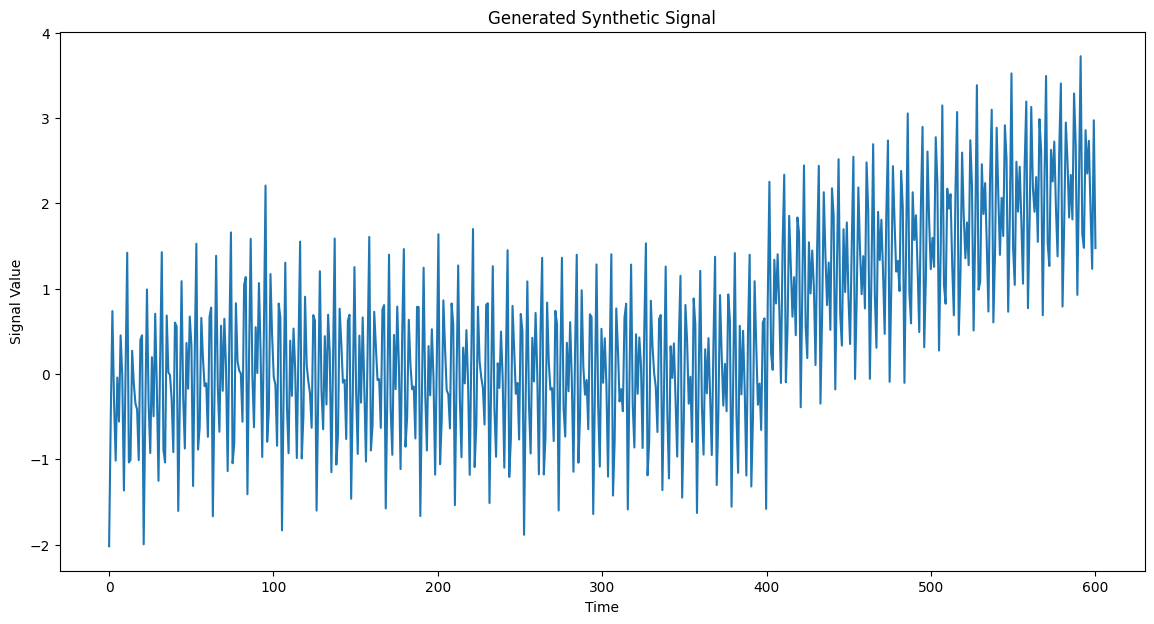

In [44]:
from scipy import signal

t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t)
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63)
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0, 0.1056, 600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]


# Display the entire signal
plt.figure(figsize=(14, 7))
plt.plot(t, pts)
plt.title('Generated Synthetic Signal')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.show()


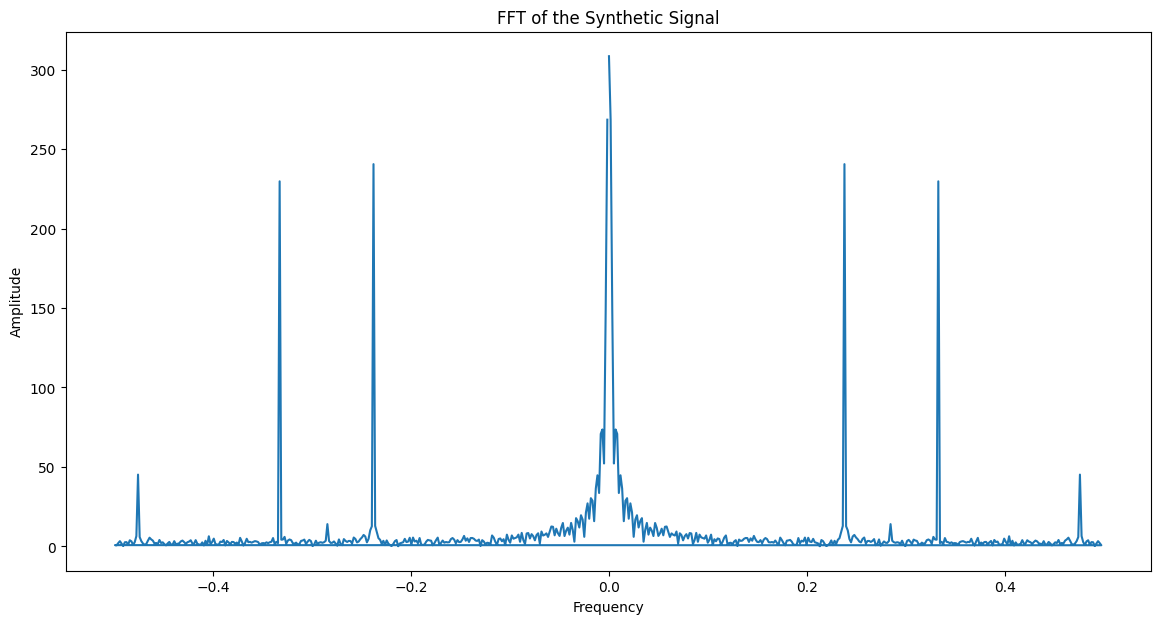

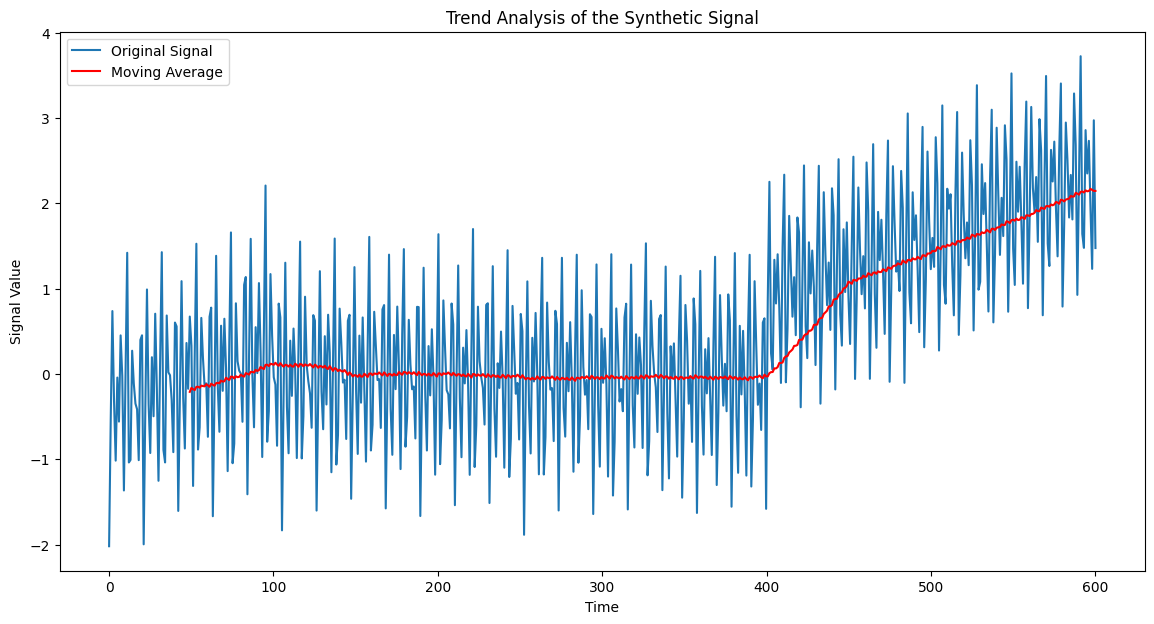

In [45]:
# Periodicity analysis using FFT
fft_vals = np.fft.fft(pts)
fft_freqs = np.fft.fftfreq(len(pts), t[1] - t[0])
plt.figure(figsize=(14, 7))
plt.plot(fft_freqs, np.abs(fft_vals))
plt.title('FFT of the Synthetic Signal')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

# Moving average for trend analysis
window_size = 50
moving_avg = np.convolve(pts, np.ones(window_size)/window_size, mode='valid')
plt.figure(figsize=(14, 7))
plt.plot(t, pts, label='Original Signal')
plt.plot(t[window_size-1:], moving_avg, label='Moving Average', color='red')
plt.title('Trend Analysis of the Synthetic Signal')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

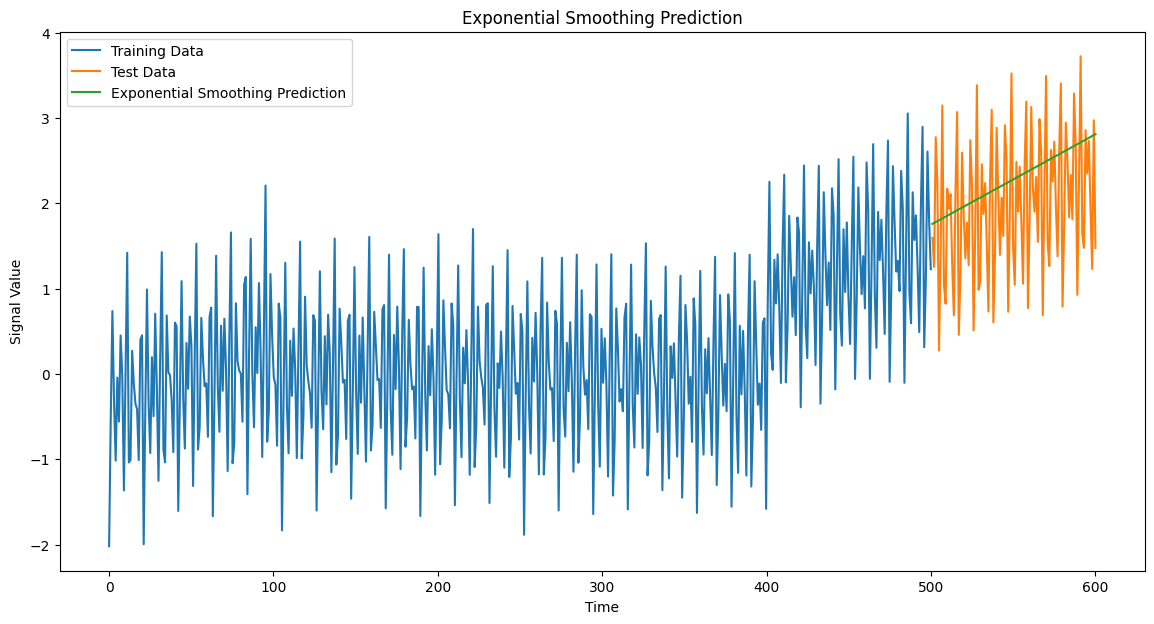

Exponential Smoothing RMSE: 0.8469385444985142, MAE: 0.6940707133501902


In [46]:
model_exp = ExponentialSmoothing(pts_train, trend='add', seasonal=None, seasonal_periods=None)
fit_exp = model_exp.fit()
pred_exp = fit_exp.forecast(len(pts_test))

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(t[:n_train_rows], pts_train, label='Training Data')
plt.plot(t[n_train_rows:], pts_test, label='Test Data')
plt.plot(t[n_train_rows:], pred_exp, label='Exponential Smoothing Prediction')
plt.title('Exponential Smoothing Prediction')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

# Calculate errors
rmse_exp = np.sqrt(mean_squared_error(pts_test, pred_exp))
mae_exp = mean_absolute_error(pts_test, pred_exp)
print(f"Exponential Smoothing RMSE: {rmse_exp}, MAE: {mae_exp}")

Best p: 5
Best d: 2
Best q: 4
Optimized RMSE: 0.25926947905572073
Optimized MAE: 0.17324419008210662


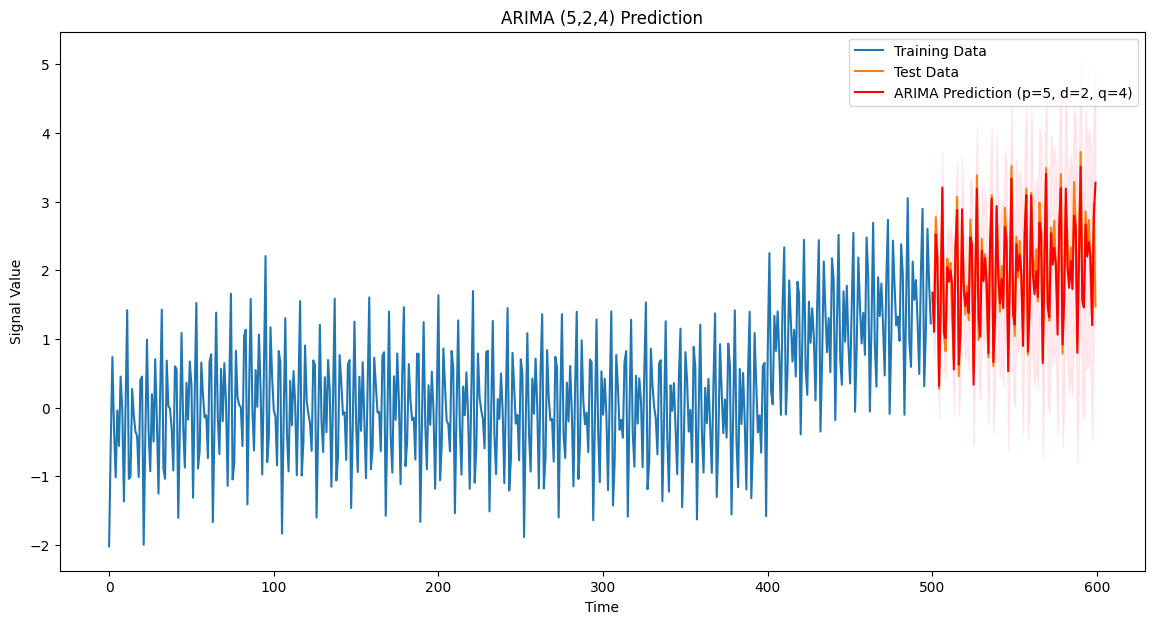

In [56]:
#optimal parameters for ARIMA
# best_model_arima, best_pdq, best_rmse_arima, best_mae_arima = ARIMAOptimization(pts_train, pts_test, p_values, d_values, q_values)

def bestResultARIMAGraph(y_train, y_test, best_model, best_pdq, best_rmse, best_mae):
    print(f'Best p: {best_pdq[0]}')
    print(f'Best d: {best_pdq[1]}')
    print(f'Best q: {best_pdq[2]}')
    print(f'Optimized RMSE: {best_rmse}')
    print(f'Optimized MAE: {best_mae}')

    y_pred = best_model.forecast(len(y_test))
    conf_int = best_model.get_forecast(len(y_test)).conf_int()
    conf_int_df = pd.DataFrame(conf_int)  # Convert to DataFrame

    plt.figure(figsize=(14, 7))
    plt.plot(range(len(y_train)), y_train, label='Training Data')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Data')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, label=f'ARIMA Prediction (p={best_pdq[0]}, d={best_pdq[1]}, q={best_pdq[2]})', color='red')
    plt.fill_between(range(len(y_train), len(y_train) + len(y_test)), conf_int_df.iloc[:, 0], conf_int_df.iloc[:, 1], color='pink', alpha=0.3)
    plt.legend()
    plt.title(f'ARIMA ({best_pdq[0]},{best_pdq[1]},{best_pdq[2]}) Prediction')
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.show()

# Plot best ARIMA results
bestResultARIMAGraph(pts_train, pts_test, best_model_arima, best_pdq, best_rmse_arima, best_mae_arima)



19:24:39 - cmdstanpy - INFO - Chain [1] start processing
19:24:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\kpali\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties

Prophet RMSE: 0.8142354765807402, MAE: 0.6581297902533882


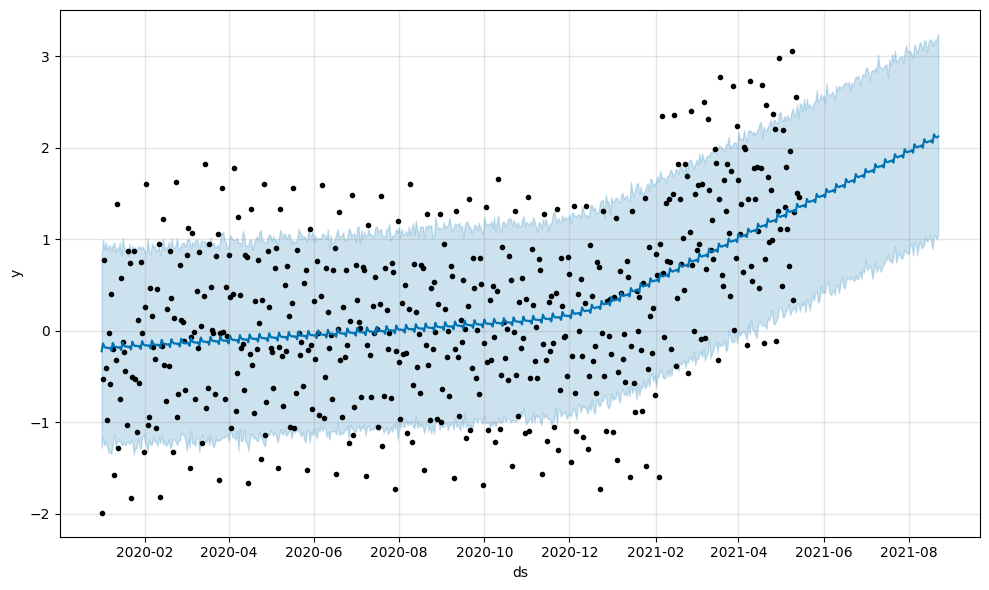

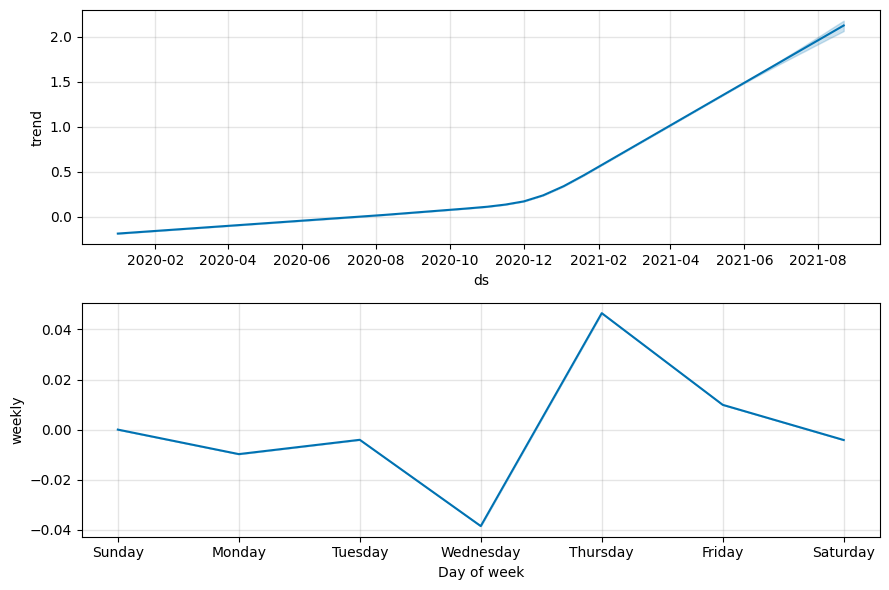

In [59]:
# Generate the synthetic signal
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t)
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63)
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0, 0.1056, 600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# Constants
last_n_rows = 600
n_train_rows = 500

# Split the data
pts_train = pts[:n_train_rows]
pts_test = pts[n_train_rows:]

# Convert t to datetime
start_date = pd.to_datetime('2020-01-01')
dates = [start_date + pd.Timedelta(days=int(x)) for x in t]

# Prepare data for Prophet
df_train = pd.DataFrame({'ds': dates[:n_train_rows], 'y': pts_train})
df_test = pd.DataFrame({'ds': dates[n_train_rows:], 'y': pts_test})

# Apply Prophet
model_prophet = Prophet()
model_prophet.fit(df_train)
future = model_prophet.make_future_dataframe(periods=len(pts_test))
forecast = model_prophet.predict(future)

# Plot results
fig1 = model_prophet.plot(forecast)
fig2 = model_prophet.plot_components(forecast)

# Calculate errors
y_pred_prophet = forecast['yhat'].iloc[n_train_rows:].values
rmse_prophet = np.sqrt(mean_squared_error(pts_test, y_pred_prophet))
mae_prophet = mean_absolute_error(pts_test, y_pred_prophet)
print(f"Prophet RMSE: {rmse_prophet}, MAE: {mae_prophet}")
